In [1]:
#import relevant libraries
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner
from JSON_to_DF import JSON_to_DataFrame
%matplotlib notebook

In [2]:
#read in firth dataset
firth_data = pd.read_csv('data/firth_data.txt', delim_whitespace=True, header=1)

#SN2011fe max date
MJD_max_2011fe = 55814
z_2011fe = 0.000804

/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


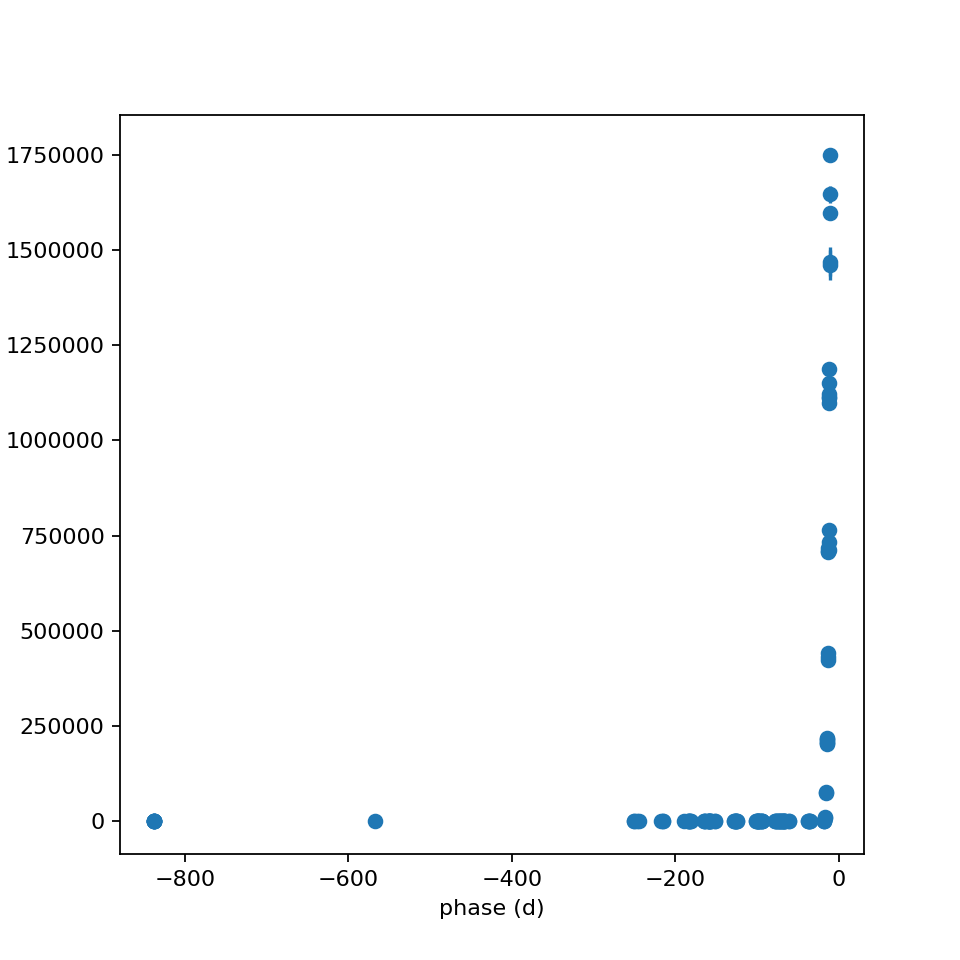

In [3]:
#filter for just 2011fe data
SN2011fe_ind = np.where(firth_data['#SNNAME'] == 'PTF11kly')
SN2011fe = firth_data.iloc[SN2011fe_ind]

#add phase column, and convert to SN restframe
SN2011fe['phase'] = (SN2011fe['OBSDATE(MJD)'] - MJD_max_2011fe) / (1 + z_2011fe)


#filter for early indices (phase < -10 days)
SN2011fe_early_ind = np.where(SN2011fe['phase'] < -10)
SN2011fe_early = SN2011fe.iloc[SN2011fe_early_ind]

#grab early flux phase and flux errors
flux = np.array(SN2011fe_early['COUNTS'])
phase = np.array(SN2011fe_early['phase'])
flux_err = np.array(SN2011fe_early['COUNTS_ERROR'])

#plot light curve
plt.figure(figsize=(6,6))
plt.errorbar(phase, flux, yerr=flux_err, fmt='o')
plt.xlabel('phase (d)')
plt.ylabel('Counts')
plt.show()

# MCMC Analysis 

In [4]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

#set parameter names
paramsNames=['a', 
           'b', 't_0', 'alpha']

In [5]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha = theta
 
    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    model[~pre_exp] = a + (b*((t[~pre_exp] - t_0)**alpha))
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (f_err**2 ))) - ((f - model)**2 / (2 * (f_err**2))))
    return ln_l

#Define wide, flat priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha,= theta
    if(-30 < t_0 < 30 and -10 < alpha < 10 and -1000000 < a < 10000000 and -1000000 < b < 1000000):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior

In [6]:
#initial guess on parameters
guess_0 = [0 , 10000, -18, 2]

#number of walkers
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=6

#initial position of walkers
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]



## Run MCMC Analysis on early 2011fe data

In [134]:
#create sampler in g band and run it
sampler_g = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(flux, phase, flux_err) , threads = ncores)
nsamples = 50000
foo = sampler_g.run_mcmc(pos, nsamples)

In [142]:
# set a "burn-in" limit
nburn = 25000

#Grab alpha and t_0 samples from all walkers
alpha_samples_g = np.array(sampler_g.chain[:,:nburn,3]).flatten()
t_0_samples_g = np.array(sampler_g.chain[:,:nburn,2]).flatten()
a_samples_g = np.array(sampler_g.chain[:,:nburn,0]).flatten()
#sig_0_samples_g = np.array(sampler_g.chain[:,:nburn,4]).flatten()
b_samples_g = np.array(sampler_g.chain[:,:nburn,1]).flatten()


#print the median taking 1-sigma confidence intervals
samples_g = np.vstack([t_0_samples_g, alpha_samples_g, a_samples_g, b_samples_g]).T

In [143]:
t_0_mc_g, alpha_mc_g, a_mc_g, b_mc_g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_g, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n \
      a = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], 
              alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2], 
              a_mc_g[0], a_mc_g[1], a_mc_g[2],
              b_mc_g[0], b_mc_g[1], b_mc_g[2],
              ))

emcee results with 1-sigma uncertainties
       t_0 = -17.3522 +0.0046 -0.0047
       alpha = 2.1375 +0.0069 -0.0067
       a = -47.6138 +3.4882 -3.4359
       b = 28684.3964 +337.5470 -344.0020



<IPython.core.display.Javascript object>


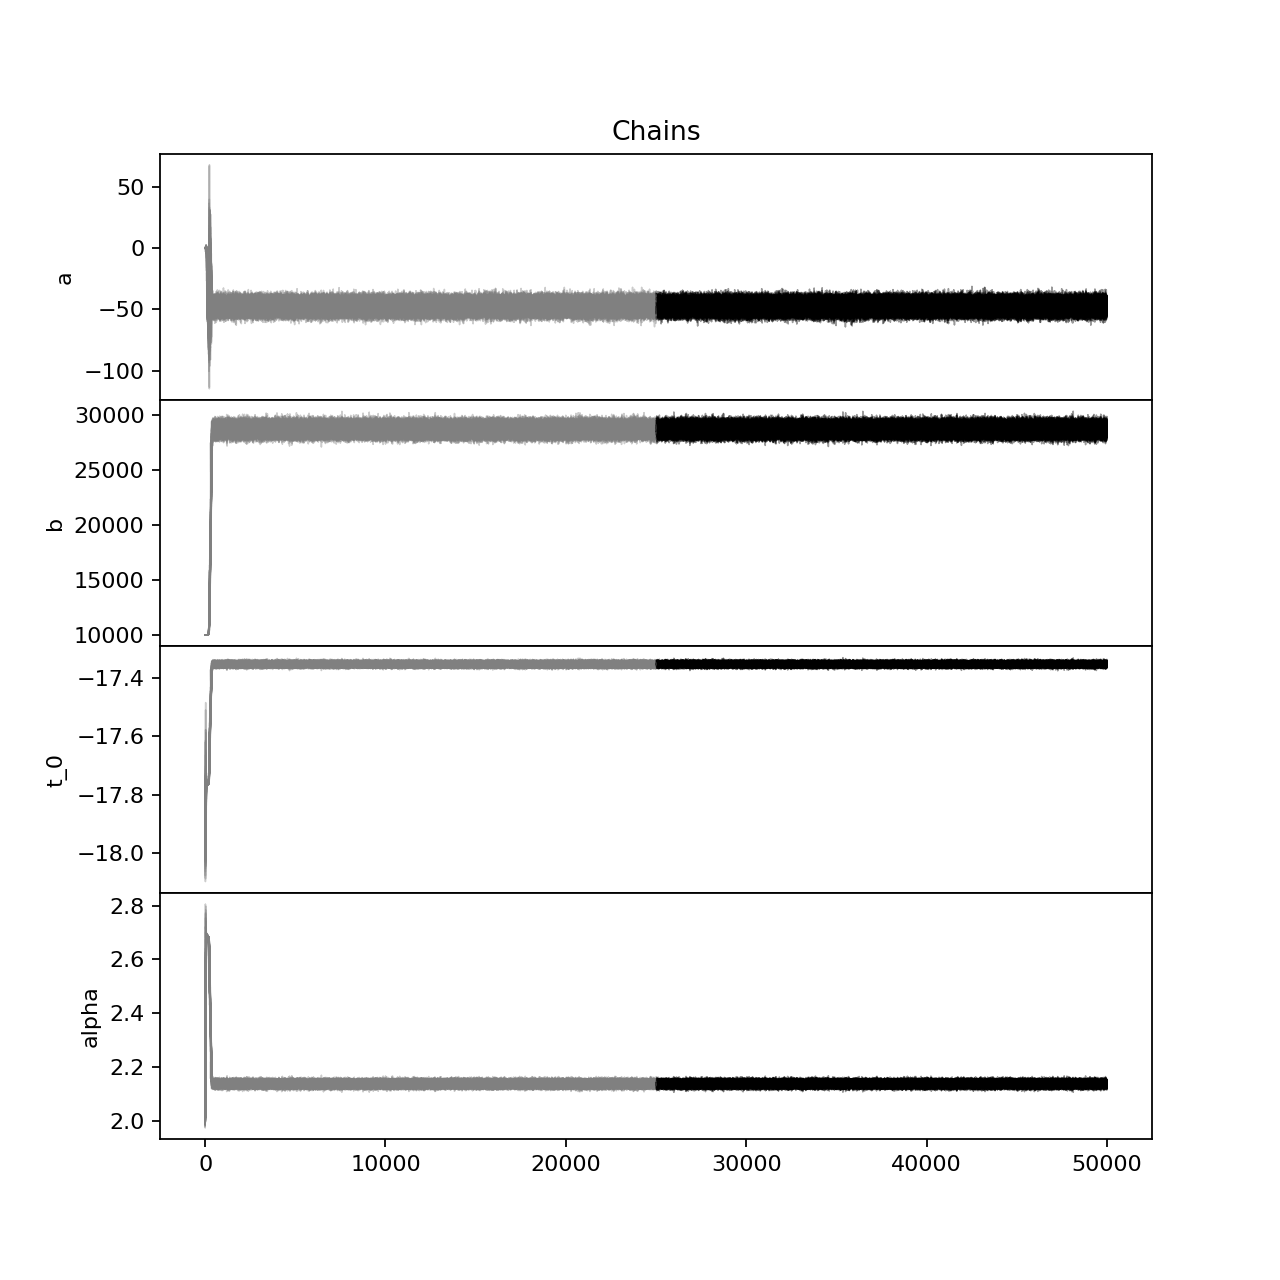

In [144]:
#plot chains
axR = plotChains(sampler_g, nburn, paramsNames)
plt.show()

<IPython.core.display.Javascript object>


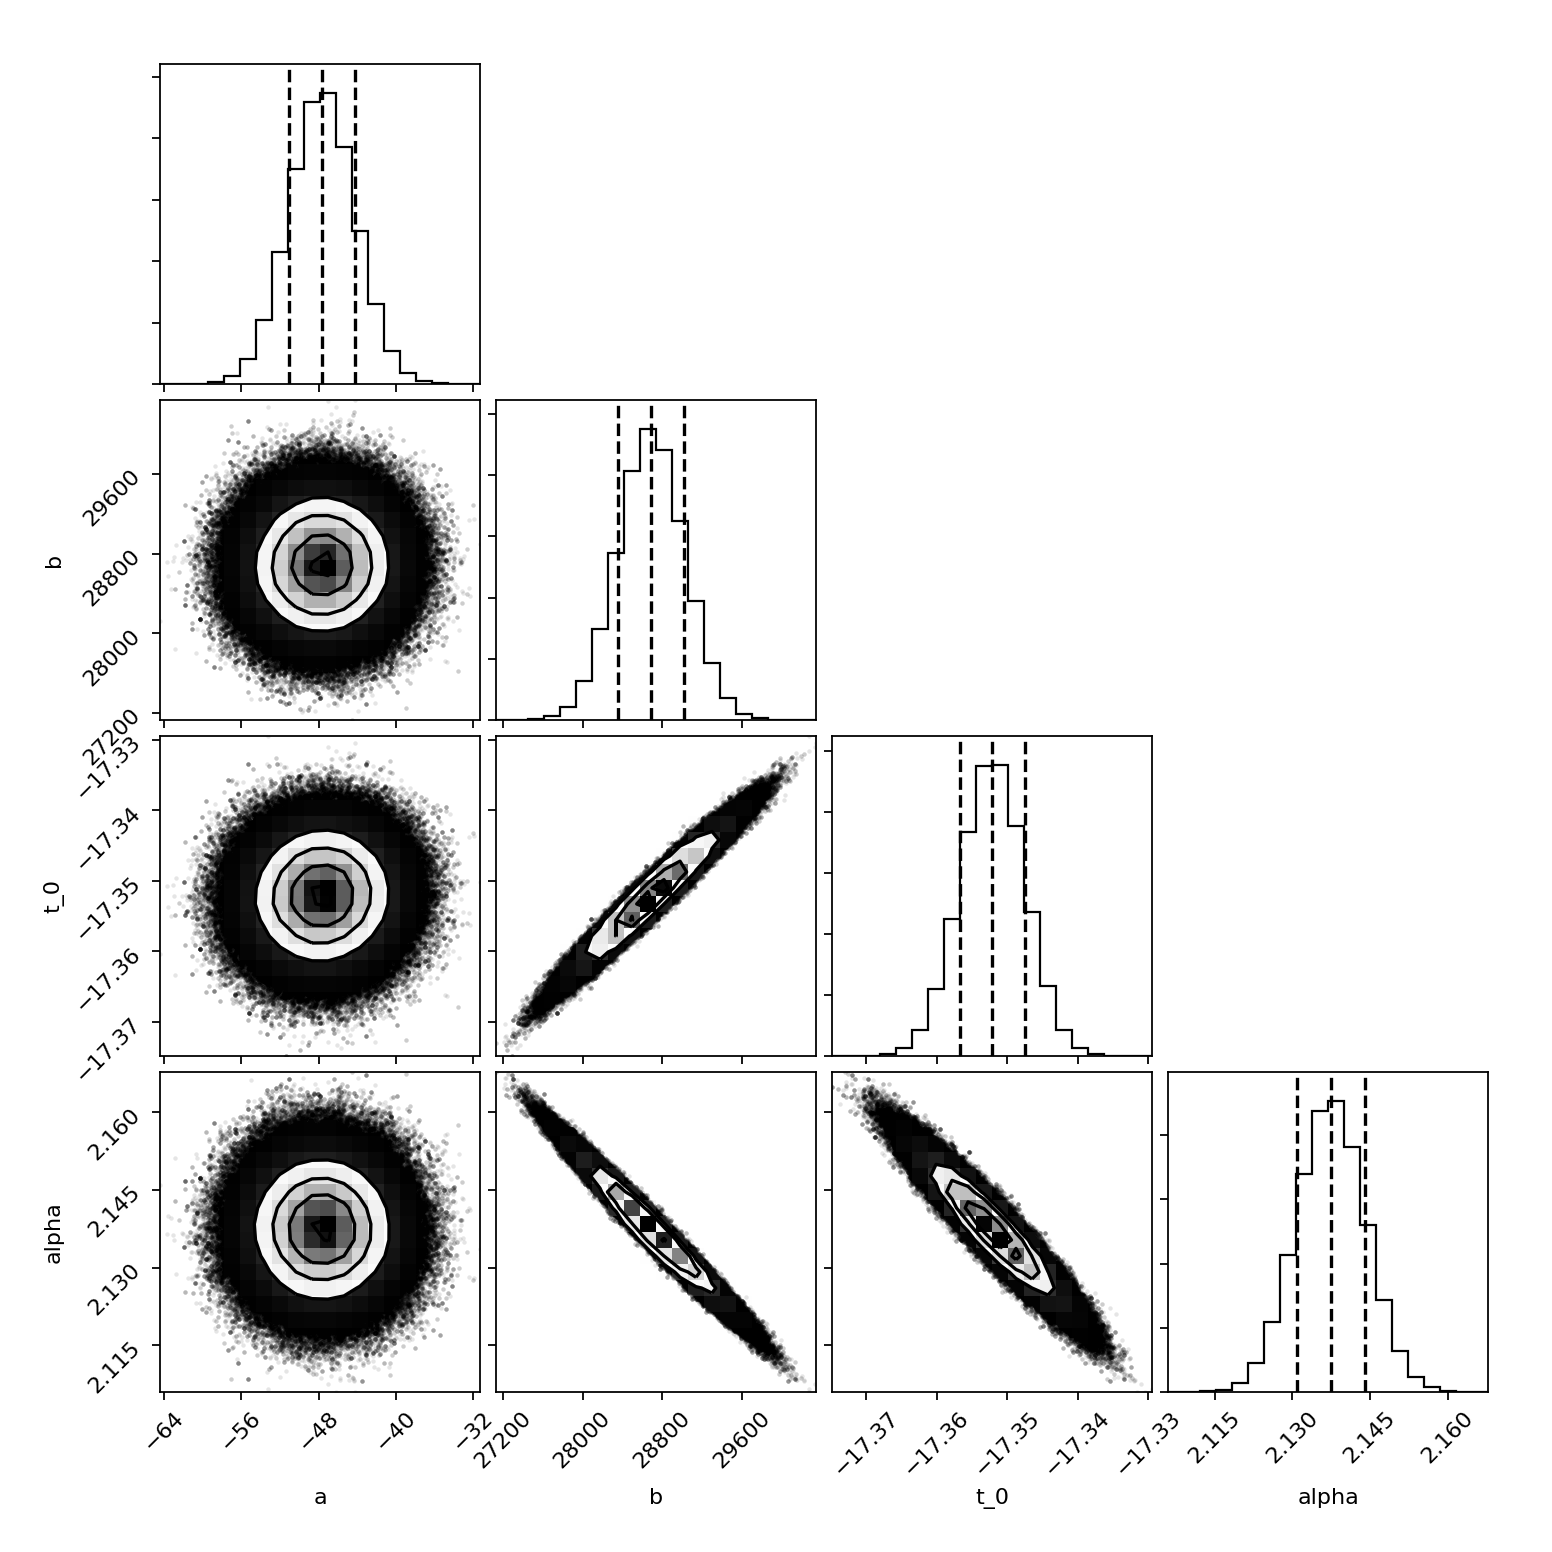

In [140]:
#make corner plot
makeCorner(sampler_g, nburn, paramsNames)
plt.show()

In [152]:
#get maximum posterior parameters in R band
post_burn_lnprob_g = sampler_g.lnprobability[:,nburn:]
max_apost_idx_g = np.unravel_index(np.argmax(post_burn_lnprob_g), post_burn_lnprob_g.shape)
post_burn_chains_g = sampler_g.chain[:,nburn:]
max_apost_theta_g = post_burn_chains_g[max_apost_idx_g[0], max_apost_idx_g[1], :]

# Run MCMC analysis on simulated noise baselines

<IPython.core.display.Javascript object>


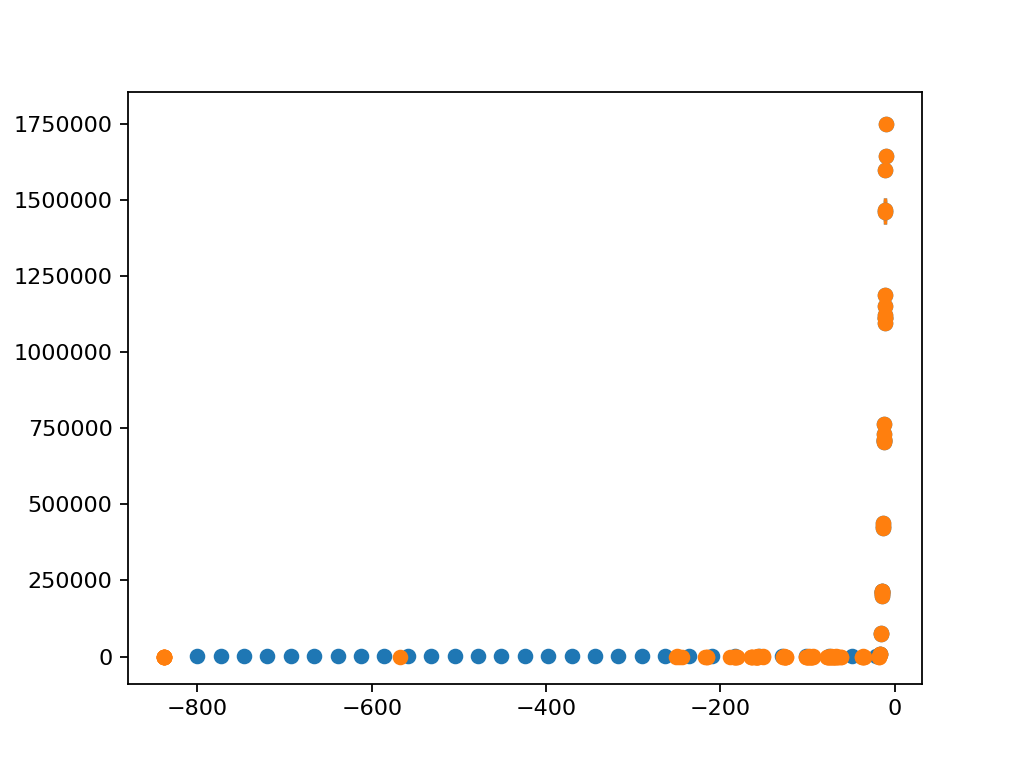

emcee results with 1-sigma uncertainties
           t_0 = -17.2777 +0.0041 -0.0042
           alpha = 2.0859 +0.0064 -0.0062
           a = 1518.9941 +3.3065 -3.2575
           b = 32233.1667 +343.1537 -350.9149


<IPython.core.display.Javascript object>


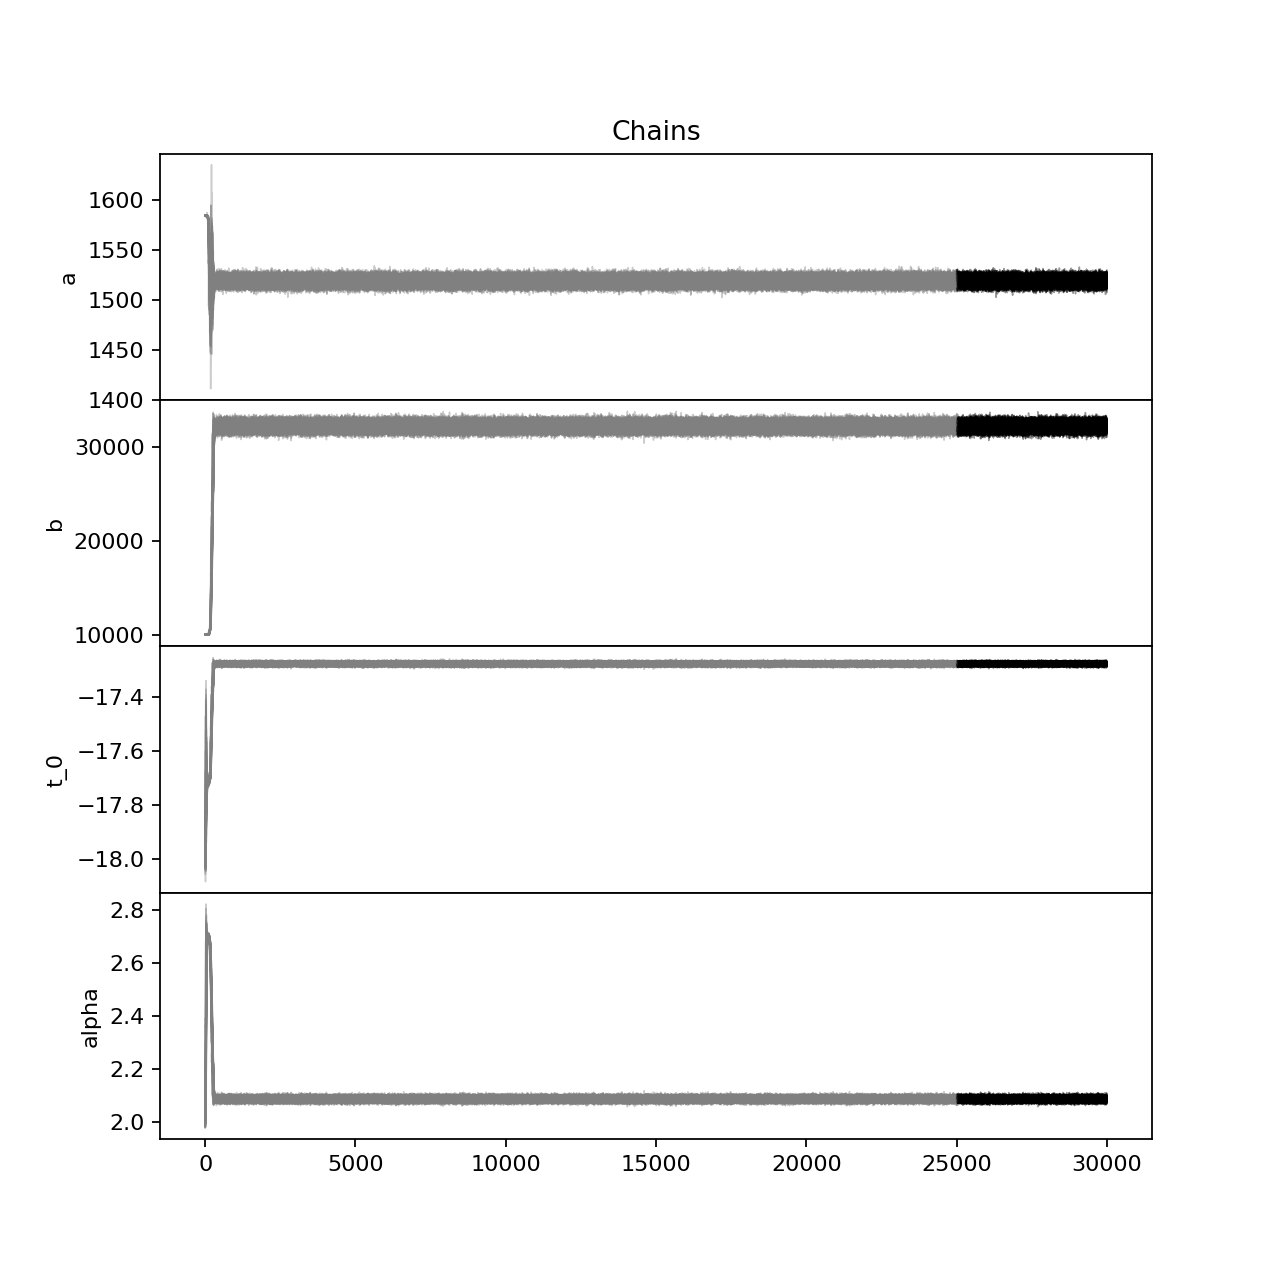

<IPython.core.display.Javascript object>


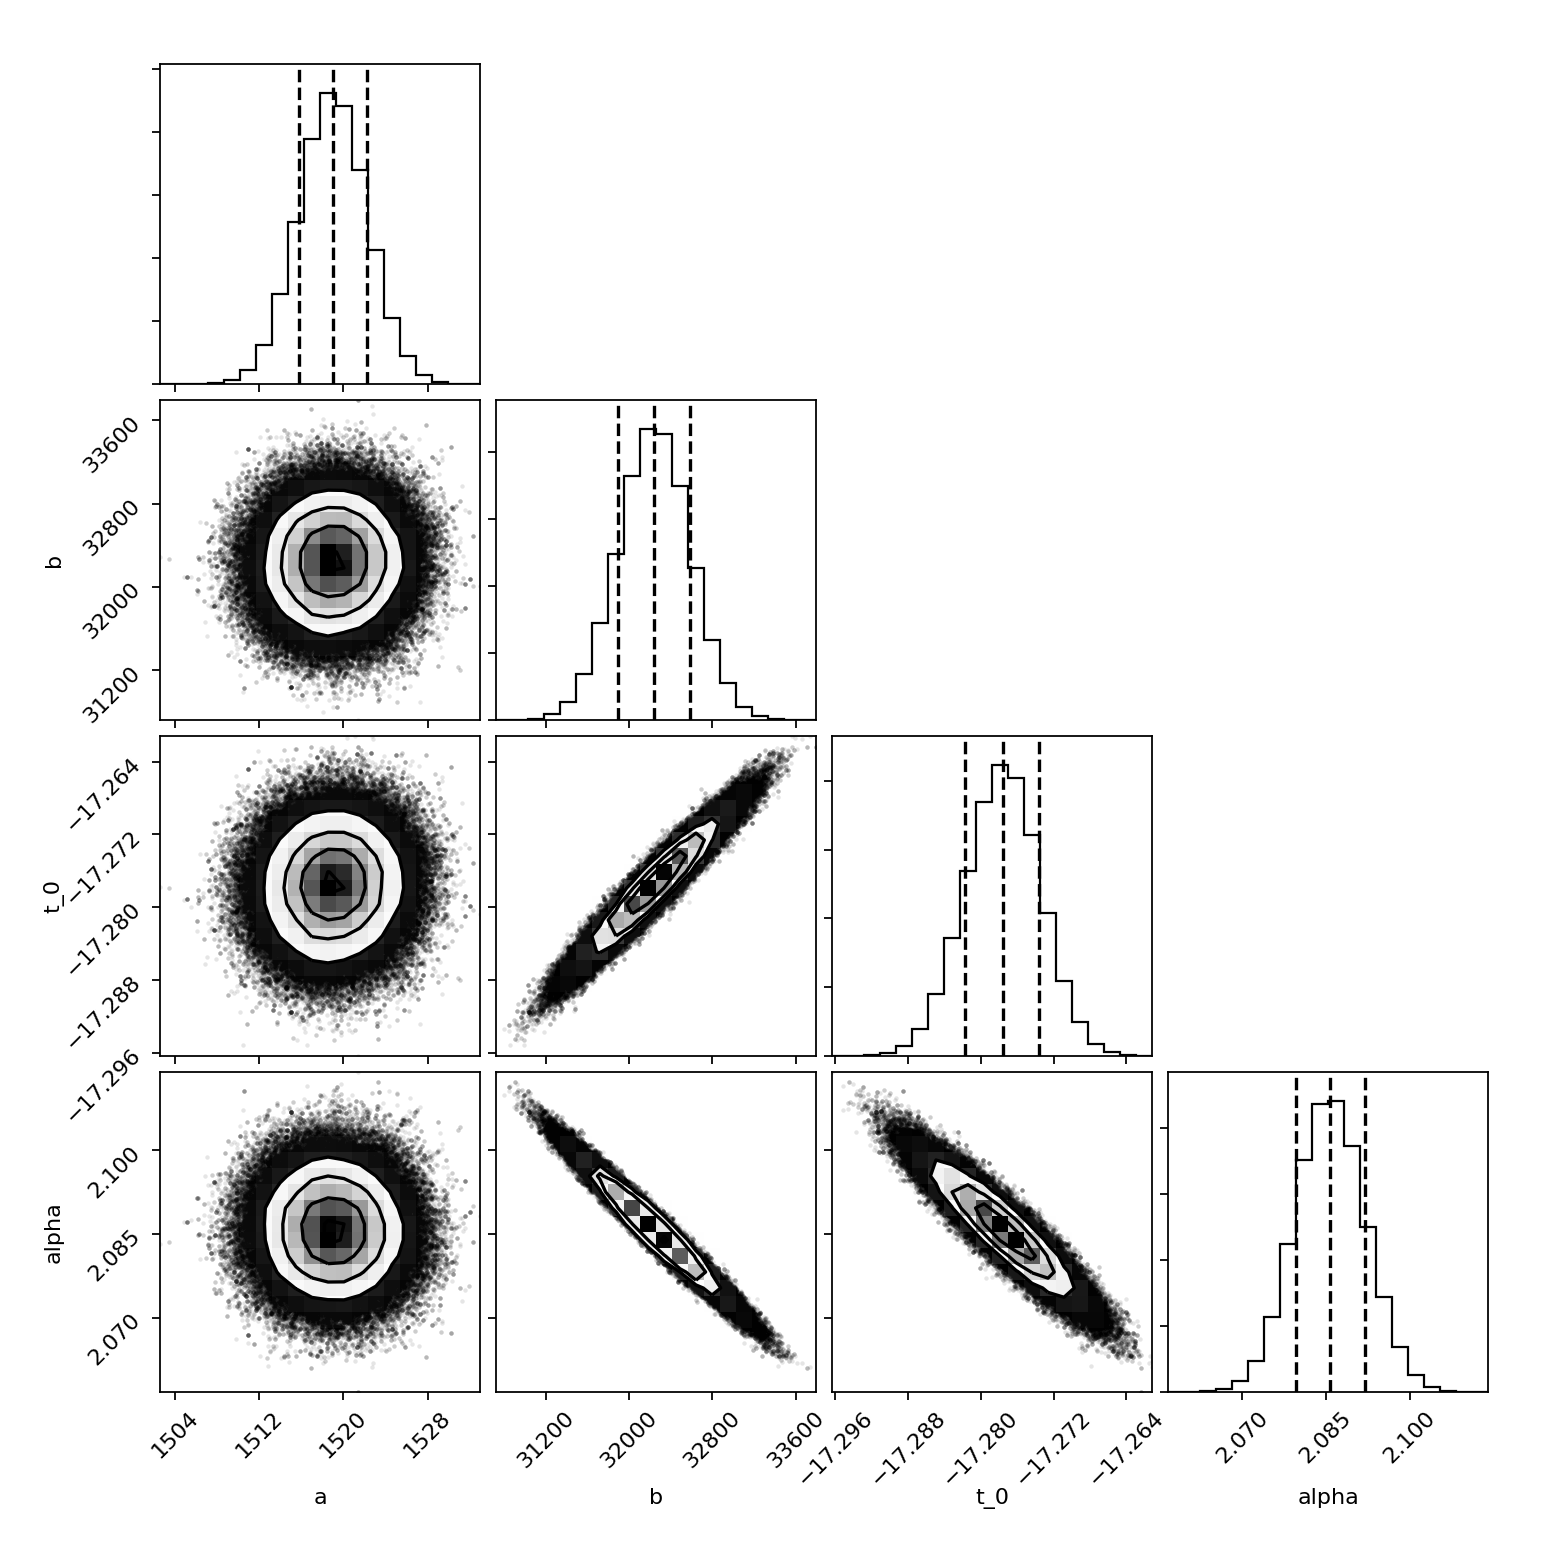

emcee results with 1-sigma uncertainties
           t_0 = -17.3326 +0.0044 -0.0045
           alpha = 2.1182 +0.0067 -0.0065
           a = 547.3773 +3.6478 -3.6323
           b = 29943.2216 +339.1710 -344.2232


<IPython.core.display.Javascript object>


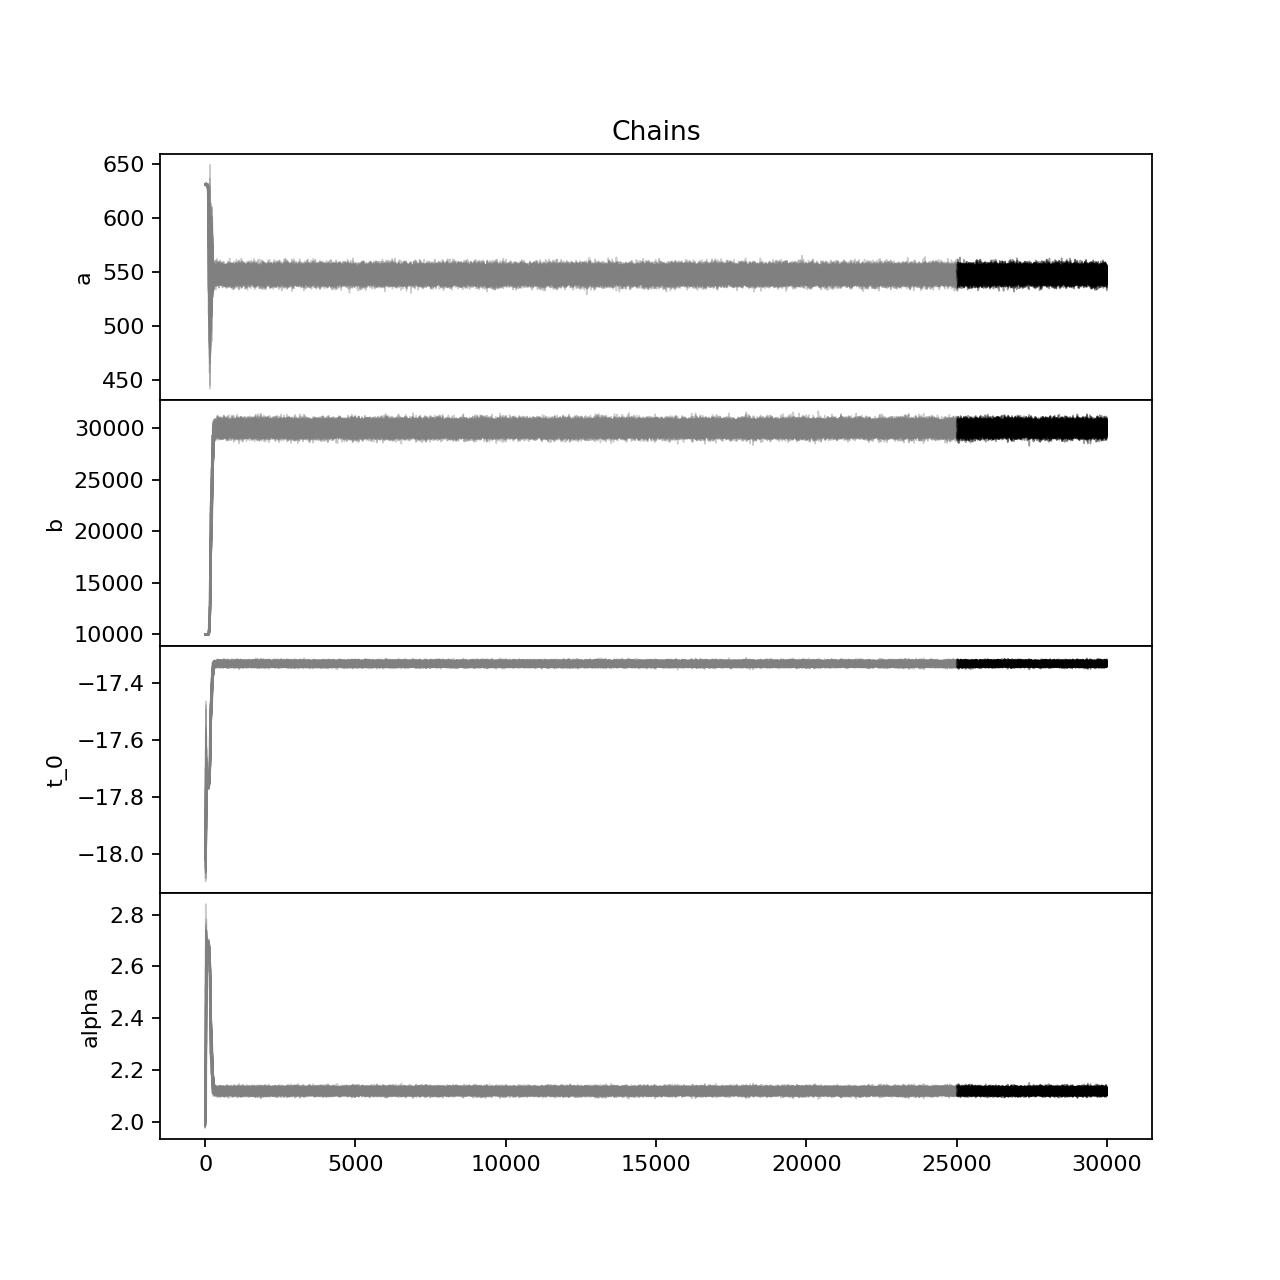

<IPython.core.display.Javascript object>


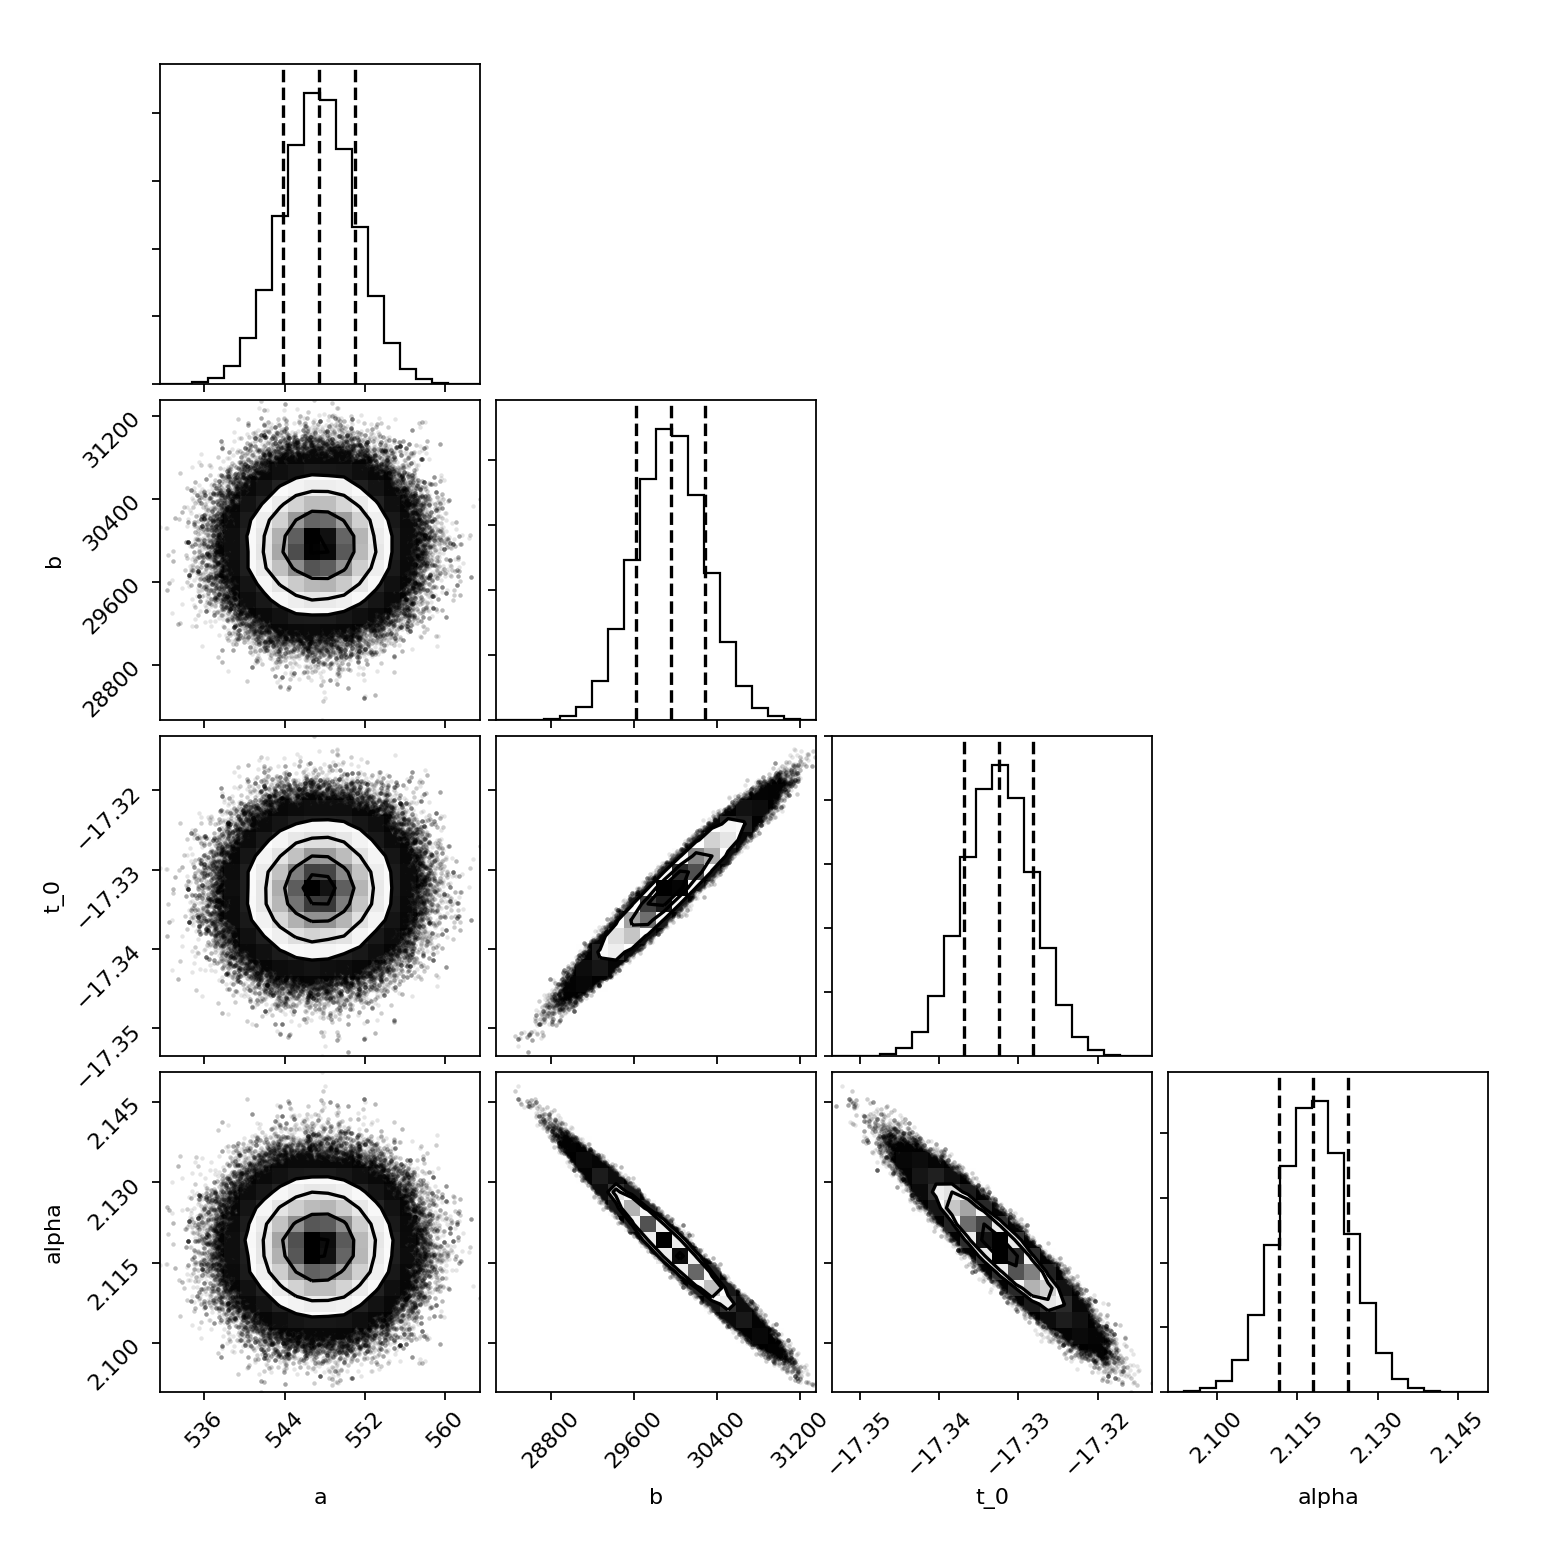

emcee results with 1-sigma uncertainties
           t_0 = -17.3499 +0.0045 -0.0046
           alpha = 2.1282 +0.0068 -0.0066
           a = 239.1507 +3.4692 -3.4308
           b = 29261.0028 +337.1815 -343.6437


<IPython.core.display.Javascript object>


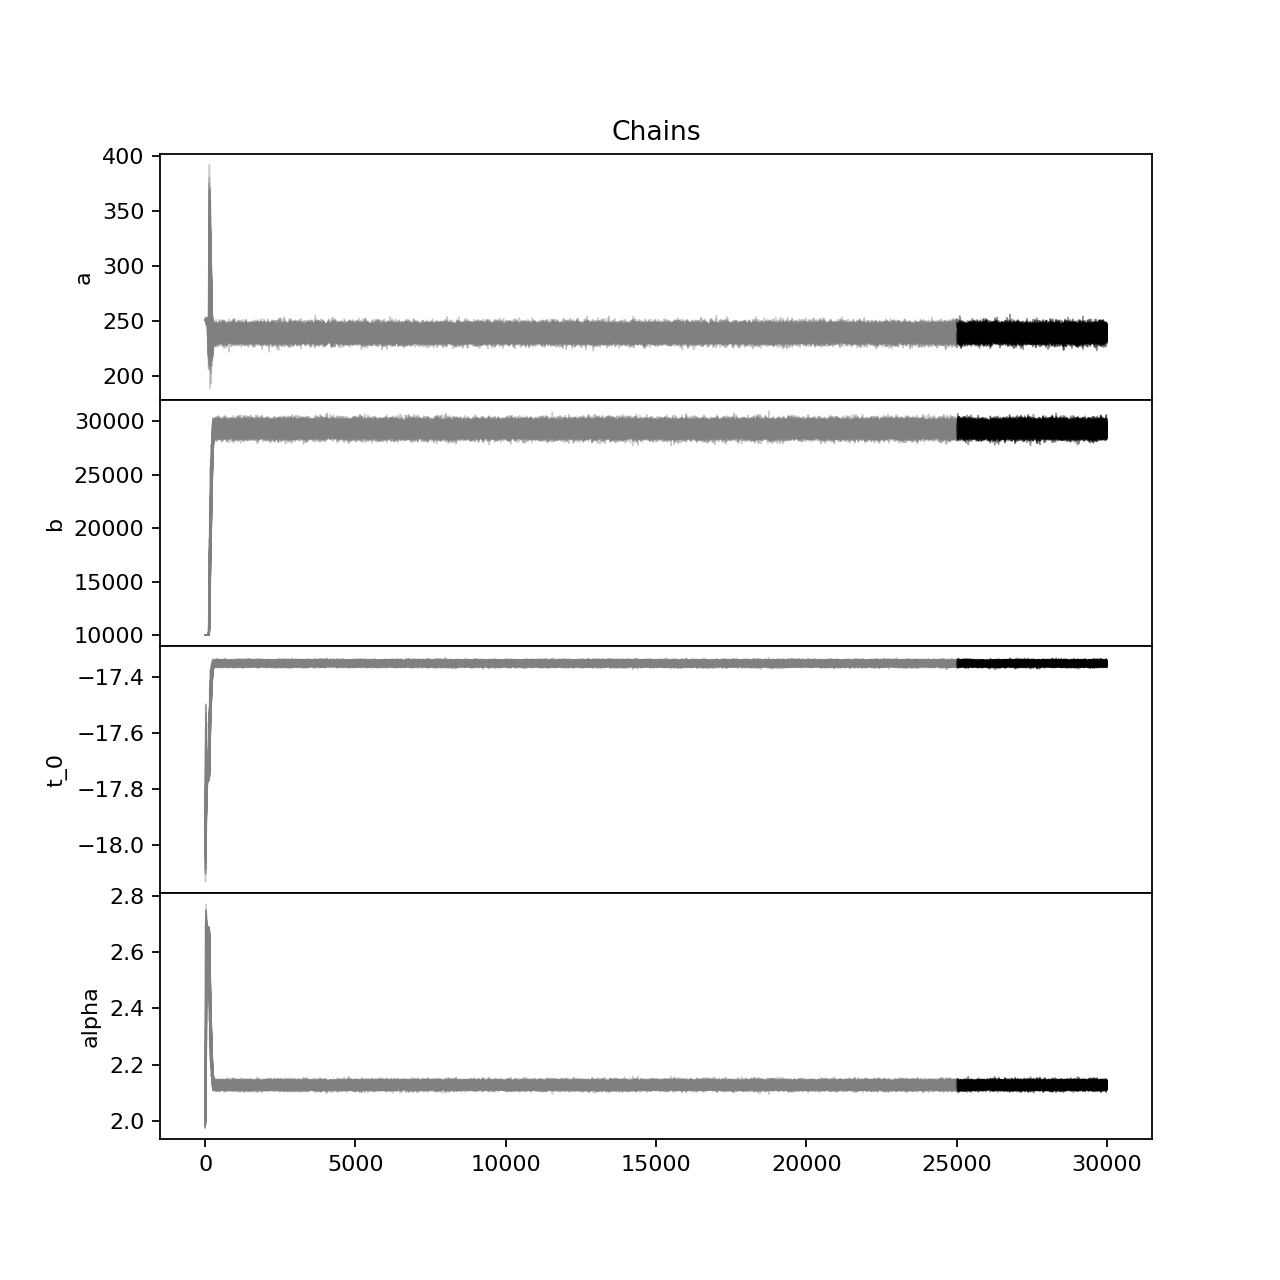

<IPython.core.display.Javascript object>


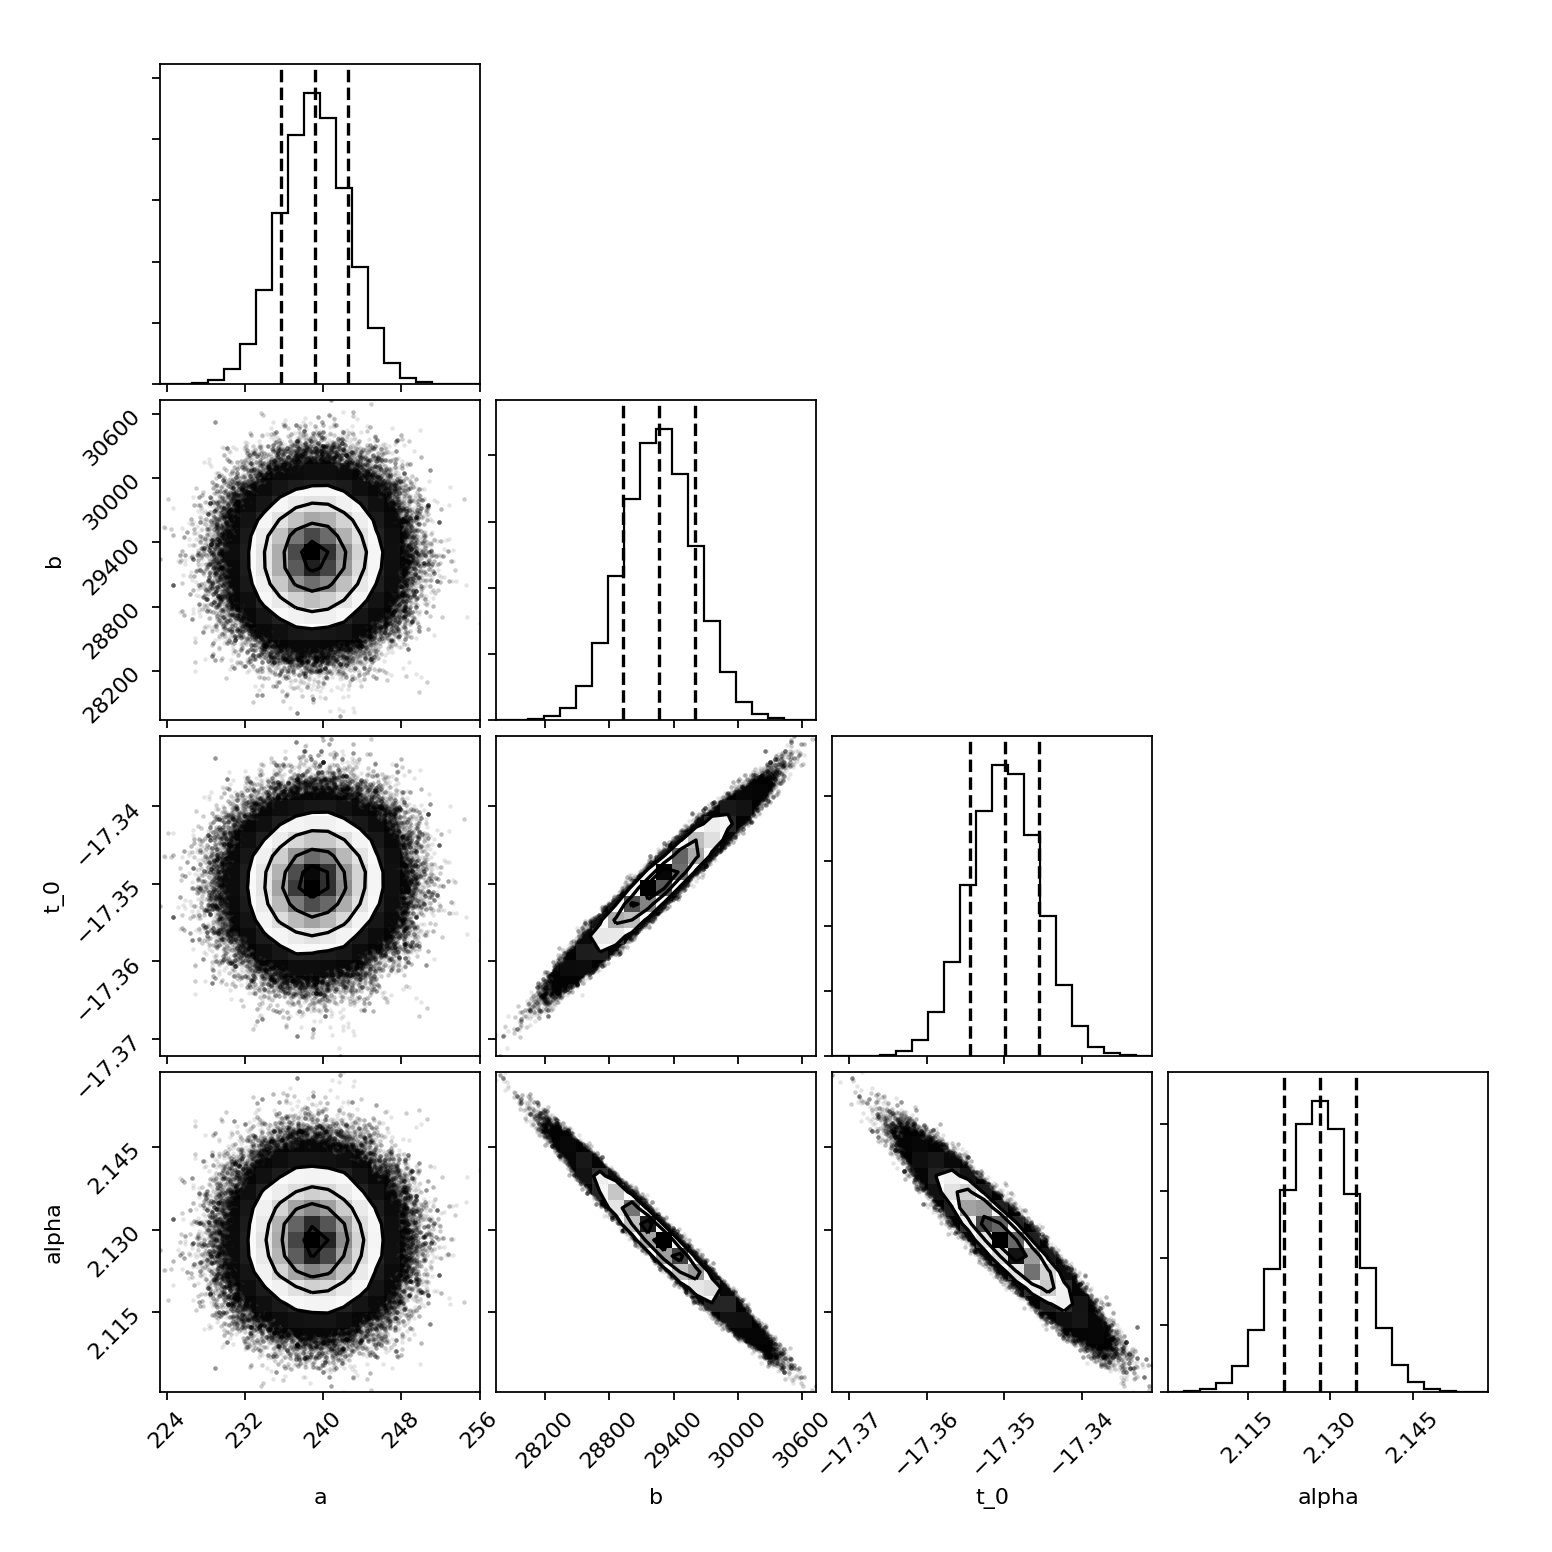

emcee results with 1-sigma uncertainties
           t_0 = -17.3576 +0.0046 -0.0047
           alpha = 2.1327 +0.0068 -0.0067
           a = 105.3911 +2.3648 -2.4021
           b = 28960.3435 +339.4965 -341.4909


<IPython.core.display.Javascript object>


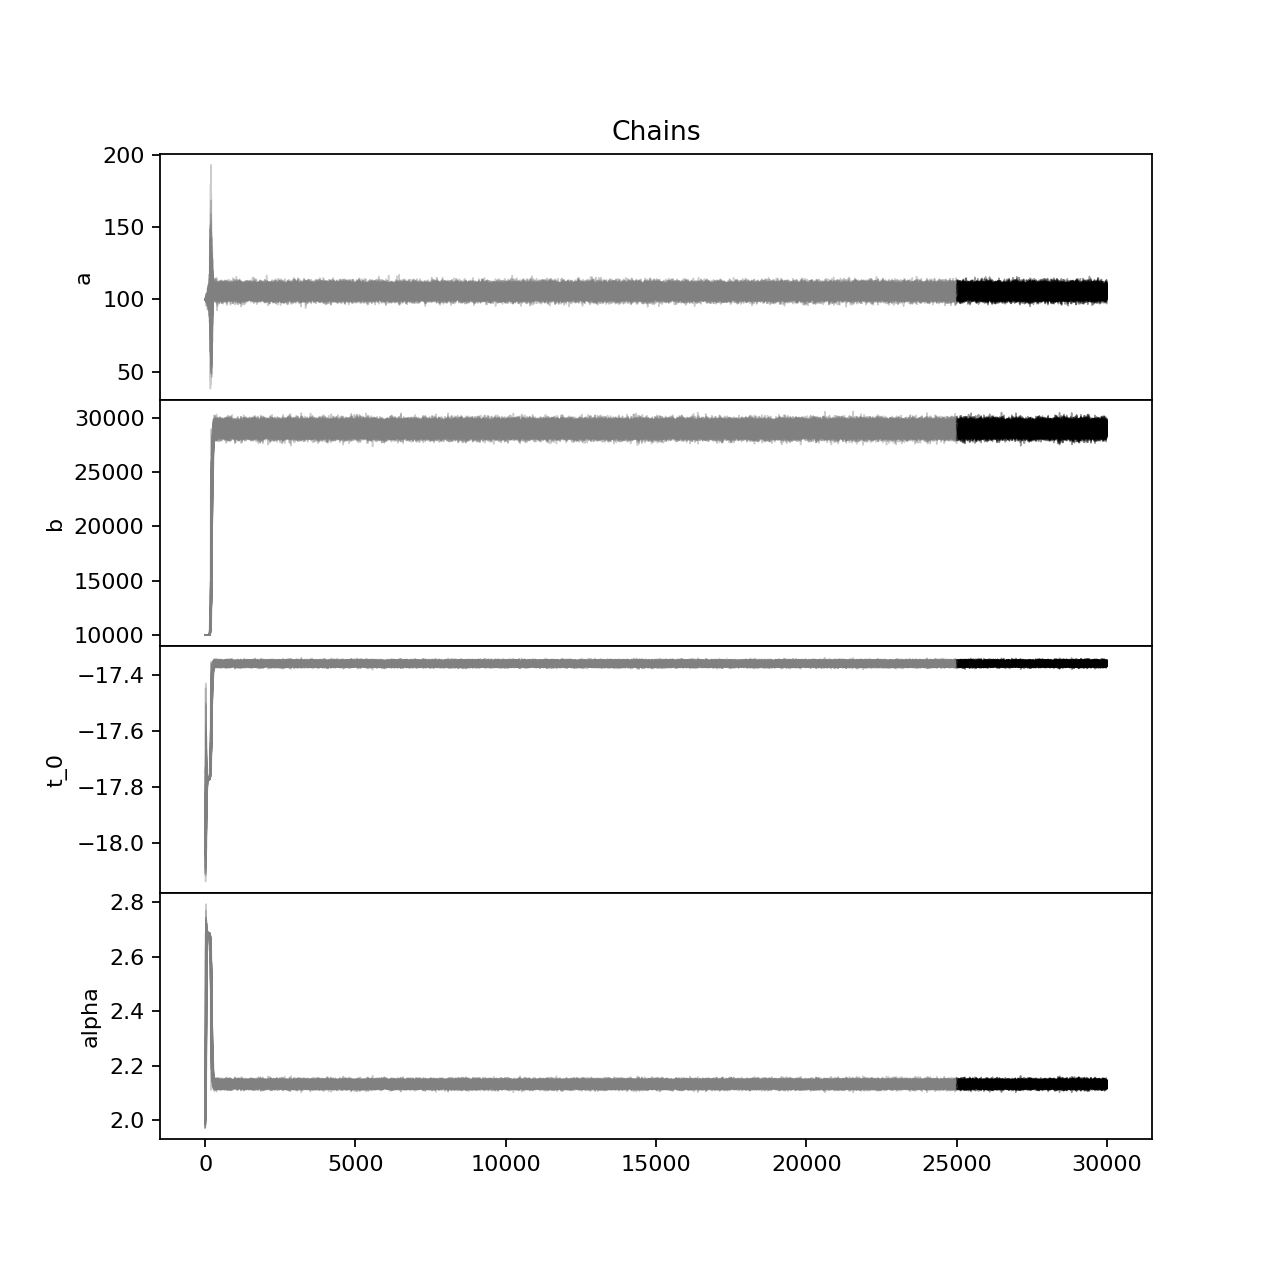

<IPython.core.display.Javascript object>


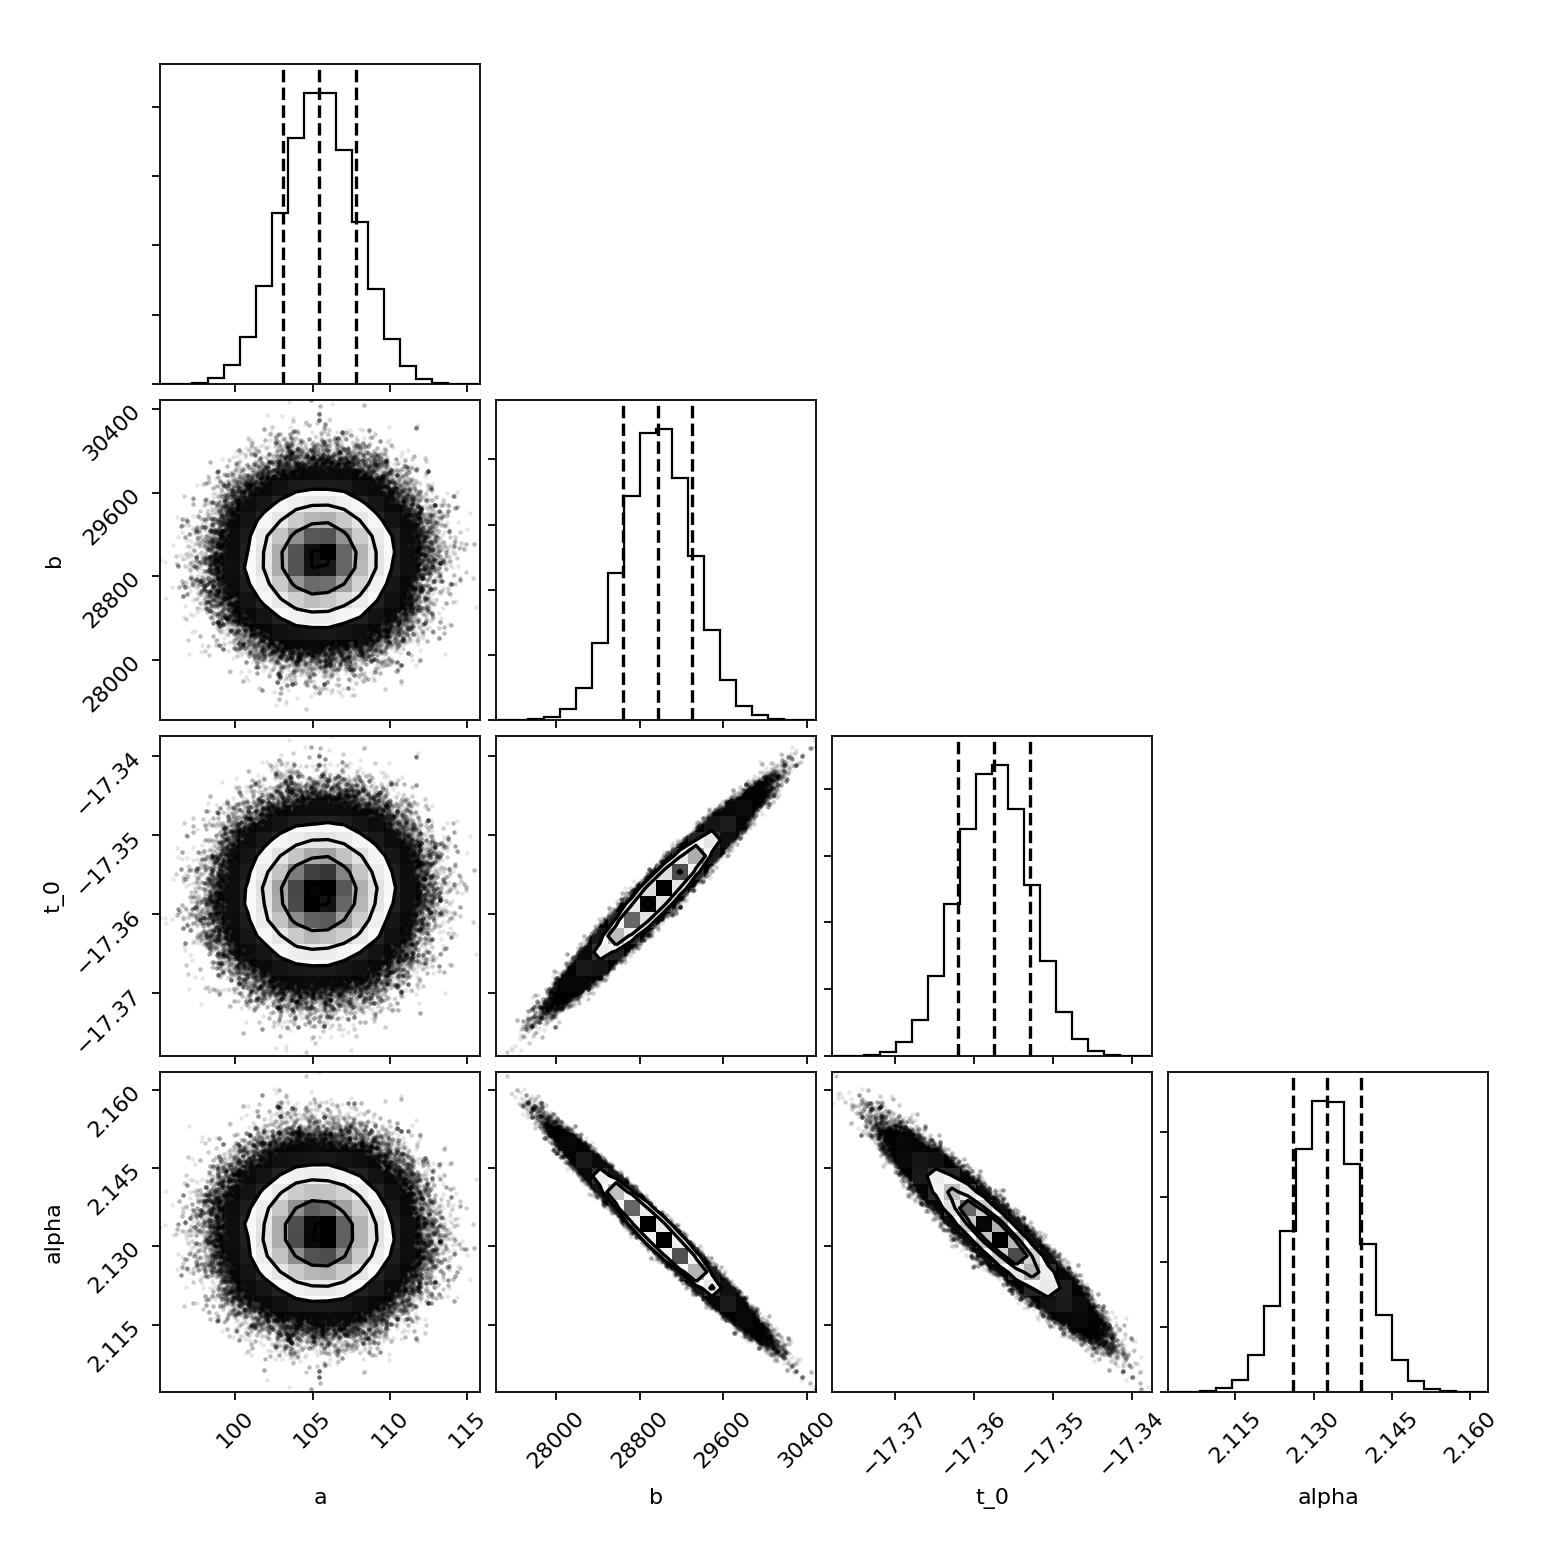

In [7]:
#baseline magnitudes
baseline_mags = np.array([17, 18, 19, 20])

#create DataFrame to store predicted t_0, and alpha parameters
predicted_data = pd.DataFrame(columns=['mag' 't_0', 'alpha', 't_0 error', 'alpha_error'])


plt.figure()

#Loop to run MCMC for each simulated baseline
for i in baseline_mags:
    
    #convert baseline from mags to counts
    baseline_count = 10**((i - 25) / -2.5)
    
    #determine 5 sigma noise limit for each baseline
    baseline_var = baseline_count / 5
    
    
    #filter for early 11fe data that is greater than baseline count limit (data detected based on limiting mag)
    indices = np.where(SN2011fe_early['COUNTS'] >= baseline_count)
    detected_11fe = np.array(SN2011fe_early['COUNTS'].iloc[indices])
    
    #Grab phases of detected 11fe data points
    phase_11fe = np.array(SN2011fe_early['OBSDATE(MJD)'].iloc[indices] - MJD_max_2011fe)
    
    #Create a noise baseline based on 5 sigma limit
    counts_baseline = np.random.normal(loc=baseline_count, scale=baseline_var, size=30)
    
    #create arbitrary phases for noise baseline
    phases_noise = np.linspace(-800, np.min(phase_11fe) -5, 30)
    
    
    #concatenae phases for noise and 11fe
    phase2 = np.concatenate((phases_noise, phase_11fe))
    
    
    #join noise baseline with 11fe data
    counts2 = np.concatenate((counts_baseline, detected_11fe))
    
    #create flux_err
    flux_err_11fe = np.array(SN2011fe_early['COUNTS_ERROR'].iloc[indices])
    
    #create error for baselines
    flux_err_noise = np.abs(np.random.normal(loc=40,scale=20, size=30))
    
    flux_err2 = np.array(np.concatenate((flux_err_noise, flux_err_11fe)))
    
    
    plt.errorbar(phase2, counts2, yerr=flux_err2  ,fmt='o')
    plt.errorbar(phase, flux, yerr=flux_err ,fmt='o')
    
    #run MCMC analysis 
    
    #initial guess on parameters
    guess_0 = [baseline_count , 10000, -18, 2]
    
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=6
    
    #intial posistion of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(counts2, phase2, flux_err2), threads=ncores)
    nsamples = 30000
    foo = sampler.run_mcmc(pos, nsamples)
    
    # set a "burn-in" limit
    nburn = 25000
    #Grab alpha and t_0 samples from all walkers
    alpha_samples_g = np.array(sampler.chain[:,:nburn,3]).flatten()
    t_0_samples_g = np.array(sampler.chain[:,:nburn,2]).flatten()
    a_samples_g = np.array(sampler.chain[:,:nburn,0]).flatten()
    
    #sig_0_samples_g = np.array(sampler_g.chain[:,:nburn,4]).flatten()
    b_samples_g = np.array(sampler.chain[:,:nburn,1]).flatten()
    
    #print the median taking 1-sigma confidence intervals
    samples_g = np.vstack([t_0_samples_g, alpha_samples_g, a_samples_g, b_samples_g]).T
    t_0_mc_g, alpha_mc_g, a_mc_g, b_mc_g  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples_g, [16, 50, 84], axis=0)))
    print("emcee results with 1-sigma uncertainties\n \
          t_0 = {:.4f} +{:.4f} -{:.4f}\n \
          alpha = {:.4f} +{:.4f} -{:.4f}\n \
          a = {:.4f} +{:.4f} -{:.4f}\n \
          b = {:.4f} +{:.4f} -{:.4f}" \
          .format(t_0_mc_g[0], t_0_mc_g[1], t_0_mc_g[2], 
                  alpha_mc_g[0], alpha_mc_g[1], alpha_mc_g[2], 
                  a_mc_g[0], a_mc_g[1], a_mc_g[2],
                  b_mc_g[0], b_mc_g[1], b_mc_g[2]))
    
    #plot chains
    axR = plotChains(sampler, nburn, paramsNames)
    plt.savefig('../Images/' + str(i) + 'sim_chains')
    
    #plot corner
    makeCorner(sampler, nburn, paramsNames)
    plt.savefig('../Images/' + str(i) + 'sim_corner')
    plt.show()
    
    #store results in dataframe
    predicted_data = predicted_data.append([i, t_0_mc_g[0], alpha_mc_g[0], [t_0_mc_g[1], t_0_mc_g[2]], [alpha_mc_g[1], alpha_mc_g[2]]])
    
    
    

In [9]:
predicted_data

Empty DataFrame
Columns: [magt_0, alpha, t_0 error, alpha_error]
Index: []

In [102]:
indices = np.where(sampler.chain[15, : ,3] > 4)
sampler.chain[15, -2 ,:]

array([ 1.58489295e+05,  3.94739735e+05, -1.44221630e+01,  9.55054055e-01])

In [103]:
def model(t, a, b, t_0, alpha):
    pre_t0 = np.logical_not(t > t_0)
    preds = np.empty_like(t)
    preds[pre_t0] = a
    preds[~pre_t0] = a + (b*((t[~pre_t0] - t_0)**alpha))

    return preds
x_vals = np.linspace(-100, 0, 1000)
y_vals = model(x_vals, *sampler.chain[15, -1 ,:])

<IPython.core.display.Javascript object>


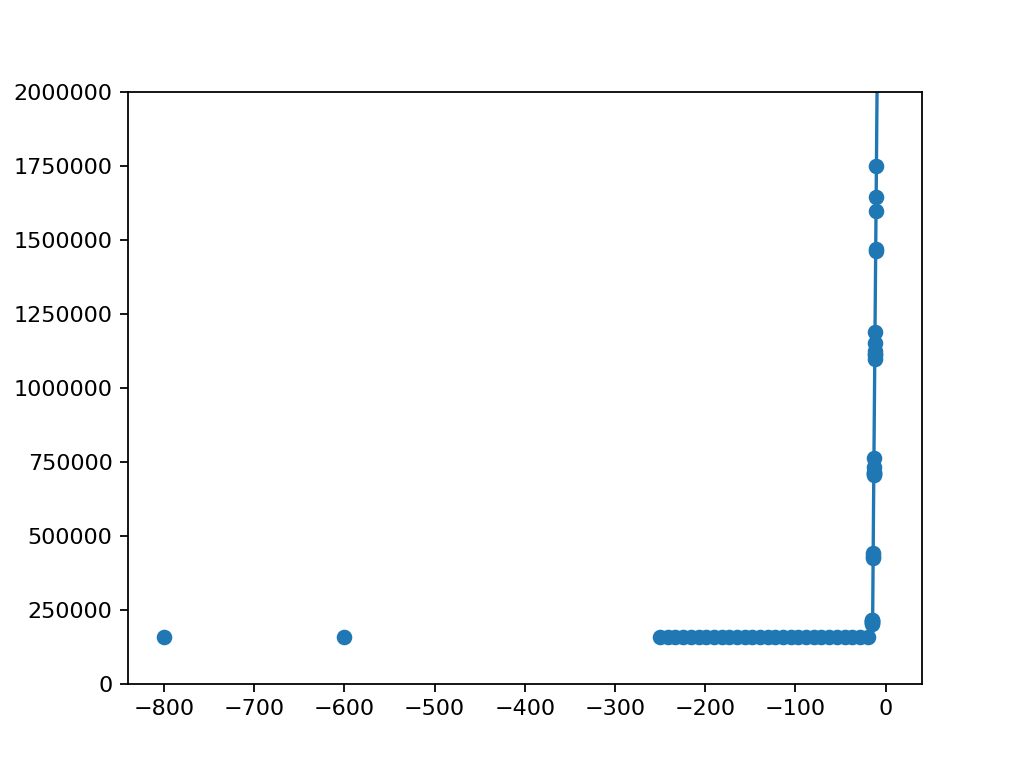

In [104]:
plt.figure()
plt.scatter(phase2, counts2)
plt.ylim([0, 2000000])
plt.plot(x_vals, y_vals)
plt.show()

In [68]:
#plot maximum posterior model with data for R band
fig = plt.figure(figsize=(6,5))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([4, 1], [0, 0], rowspan=3)

ax.errorbar(phase, flux, yerr=flux_err,
            label='g band flux', fmt='o', c='green',
            zorder=10)
ax.set_xlabel('phase (days)', fontsize=16)
ax.set_ylabel('Flux', fontsize=16)


x_vals = np.linspace(-100, -10, 1000)

def model(t, a, b, t_0, alpha):
    pre_t0 = np.logical_not(t > t_0)
    preds = np.empty_like(t)
    preds[pre_t0] = a
    preds[~pre_t0] = a + (b*((t[~pre_t0] - t_0)**alpha))

    return preds

#draw 5 random posterior samples
ndraws = 5

for post_sample in post_burn_chains_g[np.random.choice(post_burn_chains_g.shape[0], ndraws), 
                                      np.random.choice(post_burn_chains_g.shape[1], ndraws),
                                      :]:
    y_vals = model(x_vals, *post_sample[0:4])
    ax.plot(x_vals, y_vals, c='grey', alpha=.3)
ax.plot([1e9,2e9], [1e9,2e9], c='grey', alpha=.3, label= 'random posterior draws')
plt.xlim([-100, -5])
plt.ylim([-100, 100000])
#plot maximum posterior model
Y_vals = model(x_vals, *max_apost_theta_g[0:4])

ax.set_yscale("symlog", linthreshy=100, linscaley =  .5, subsy = [3,4,5,6,7,8,9])
ax.plot(x_vals, Y_vals, c="black", label='bestfit')
ax.set_yticks([-100, -50, 0, 50, 100, 1000])
ax.set_yticklabels([-100, -50, 0, 50, 100, 1000])
ax.set_title('g band fit')

ax.legend(fontsize=12)
fig.tight_layout()

array([ 158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        158489.31924611,  158489.31924611,  158489.31924611,
        200285.9       ,  207963.5       ,  204910.        ,
        212324.3       ,  216081.4       ,  214842.1       ,
        430674.8       ,  423187.8       ,  440127.7       ,
        709559.3       ,  706779.6       ,  716481.8       ,
        732285.7       ,  763636.7       ,  712601.1       ,
       1097469.4       , 1114191.2       , 1112331.6       ,
       1151702.9       ,